In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import librosa as lb
import librosa.display as lbd
import os
tf.random.set_seed(100)
np.random.seed(100)

In [ ]:
train=pd.read_csv('/content/drive/My Drive/MEMS Google Colabs/csv_data/train.csv')
val=pd.read_csv('/content/drive/My Drive/MEMS Google Colabs/csv_data/val.csv')
train.head()

,Unnamed: 0,Start_time,End_Time,Wheezing,Patient_ID,Mode,File_Name,Audio_Name
0,5336,2.1450,7.788,0,200,mc,200_2p3_Al_mc_AKGC417L,200_2p3_Al_mc_AKGC417L_0.wav
1,3058,11.1600,15.401,1,160,mc,160_1b4_Al_mc_AKGC417L,160_1b4_Al_mc_AKGC417L_2.wav
2,1945,10.6500,13.321,0,135,mc,135_2b1_Al_mc_LittC2SE,135_2b1_Al_mc_LittC2SE_5.wav
3,1475,6.9447,7.997,1,124,sc,124_1b1_Ar_sc_Litt3200,124_1b1_Ar_sc_Litt3200_5.wav
4,2938,14.5660,16.101,0,154,mc,154_1b3_Al_mc_AKGC417L,154_1b3_Al_mc_AKGC417L_8.wav


In [ ]:
ytrain=train.Wheezing
yval=val.Wheezing
yval

0       0
1       0
2       0
3       0
4       0
       ..
1720    0
1721    0
1722    0
1723    0
1724    0
Name: Wheezing, Length: 1725, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
ytrain=le.fit_transform(ytrain)
yval=le.transform(yval)

In [ ]:
ytrain


array([0, 1, 0, ..., 1, 1, 0])

In [ ]:
yval

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
def getFeatures(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec

In [ ]:
root='/content/drive/My Drive/MEMS Google Colabs/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in train.iterrows():
    path=root + row['Audio_Name']
    a,b,c = getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    
mfcc_train=np.array(mfcc)
cstft_train=np.array(cstft)
mSpec_train=np.array(mSpec)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
mfcc_train.shape

(5173, 20, 259)

In [ ]:
root='/content/drive/My Drive/MEMS Google Colabs/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in val.iterrows():
    path=root + row['Audio_Name']
    a,b,c =getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    
mfcc_val=np.array(mfcc)
cstft_val=np.array(cstft)
mSpec_val=np.array(mSpec)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
mfcc_train = np.reshape(mfcc_train, (5173,20,259,1))
mfcc_val = np.reshape(mfcc_val, (1725,20,259,1))
mfcc_train.shape

(5173, 20, 259, 1)

In [ ]:
mfcc_val.shape

(1725, 20, 259, 1)

In [ ]:
cstft_train = np.reshape(cstft_train, (5173,12,259,1))
cstft_val = np.reshape(cstft_val, (1725,12,259,1))
cstft_train.shape

(5173, 12, 259, 1)

In [ ]:
mSpec_train = np.reshape(mSpec_train, (5173,128,259,1))
mSpec_val = np.reshape(mSpec_val, (1725,128,259,1))
mSpec_train.shape

(5173, 128, 259, 1)

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

In [ ]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

In [ ]:
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mfccInput (InputLayer)       [(None, 20, 259, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 87, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 87, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 20, 87, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 43, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 22, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 22, 64)        25

In [ ]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")

In [ ]:
croma_model.summary()

Model: "cromaModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cromaInput (InputLayer)      [(None, 12, 259, 1)]      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 87, 32)        832       
_________________________________________________________________
batch_normalization_4 (Batch (None, 12, 87, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 12, 87, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 43, 32)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 22, 64)         18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 6, 22, 64)         2

In [ ]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")

In [ ]:
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mSpecInput (InputLayer)      [(None, 128, 259, 1)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 87, 32)        832       
_________________________________________________________________
batch_normalization_7 (Batch (None, 64, 87, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 64, 87, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 43, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 22, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 22, 64)        2

In [ ]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.6)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.6)(hidden)
output=keras.layers.Dense(2,activation='sigmoid')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")

In [ ]:
net.summary()

Model: "Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mfcc (InputLayer)               [(None, 20, 259, 1)] 0                                            
__________________________________________________________________________________________________
croma (InputLayer)              [(None, 12, 259, 1)] 0                                            
__________________________________________________________________________________________________
mspec (InputLayer)              [(None, 128, 259, 1) 0                                            
__________________________________________________________________________________________________
mfccModel (Functional)          (None, 128)          94560       mfcc[0][0]                       
________________________________________________________________________________________________

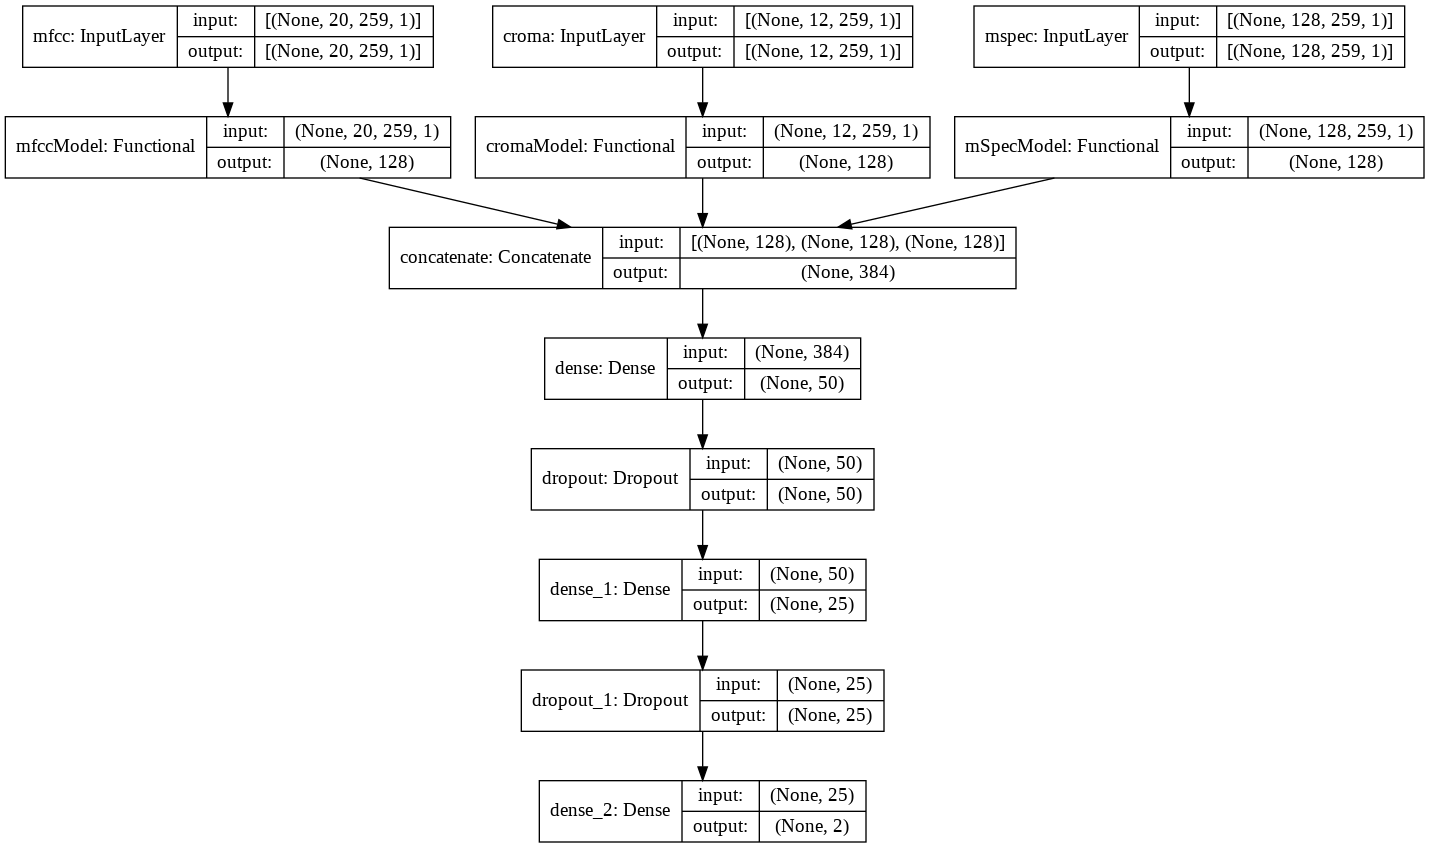

In [ ]:
keras.utils.plot_model(net, "net.png", show_shapes=True)

In [ ]:
from tensorflow.keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.0001)

In [ ]:
history=net.fit(
    {"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train},
    ytrain,
    validation_data=({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval),
    epochs=100
)

Epoch 1/100
162/162 [==============================] - 70s 402ms/step - loss: 1.0677 - accuracy: 0.6878 - val_loss: 0.7645 - val_accuracy: 0.4029
Epoch 2/100
162/162 [==============================] - 68s 420ms/step - loss: 0.6103 - accuracy: 0.7506 - val_loss: 0.5461 - val_accuracy: 0.7733
Epoch 3/100
162/162 [==============================] - 64s 394ms/step - loss: 0.5748 - accuracy: 0.7715 - val_loss: 0.5272 - val_accuracy: 0.7977
Epoch 4/100
162/162 [==============================] - 64s 396ms/step - loss: 0.5594 - accuracy: 0.7821 - val_loss: 0.5068 - val_accuracy: 0.7983
Epoch 5/100
162/162 [==============================] - 64s 396ms/step - loss: 0.5228 - accuracy: 0.7841 - val_loss: 0.5080 - val_accuracy: 0.7988
Epoch 6/100
162/162 [==============================] - 64s 397ms/step - loss: 0.5197 - accuracy: 0.7876 - val_loss: 0.4883 - val_accuracy: 0.7988
Epoch 7/100
162/162 [==============================] - 64s 395ms/step - loss: 0.5101 - accuracy: 0.7930 - val_loss: 0.4912 -

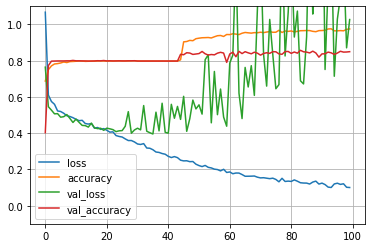

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

In [ ]:
net.evaluate({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval)

54/54 [==============================] - 5s 99ms/step - loss: 1.0273 - accuracy: 0.8499


[1.0272754430770874, 0.8498550653457642]